Prepare the environment
-----------------------

First we'll import various functions that we'll need for generating the report.

In [1]:
%matplotlib inline

from os.path import join, exists, expandvars
import pandas as pd
from skbio.draw import boxplots

from taxcompare.eval_framework import (get_expected_tables_lookup, 
                                       find_and_process_result_tables,
                                       compute_mock_results,
                                       compute_mantel,
                                       generate_pr_scatter_plots,
                                       boxplot_from_data_frame,
                                       heatmap_from_data_frame,
                                       method_by_dataset_a1,
                                       method_by_dataset_a2,
                                       performance_rank_comparisons,
                                       parameter_comparisons)

Configure local environment-specific values
-------------------------------------------

**This is the only cell that you will need to edit to generate reports locally.** After editing this cell, you can run all cells in this notebook to generate your analysis report. Some of the analyses make take a few minutes to run, and analyses at more specific taxonomic levels (e.g., genus or species) will be slower than analyses at more general taxonomic levels (e.g., phylum, class). 

**This cell will not run until you fill in a taxonomic level (``2`` through ``7``).**

In [2]:
## project_dir should be the directory where you've downloaded (or cloned) the 
## short-read-tax-assignment repository. 
project_dir = expandvars("$HOME/data/short-read-tax-assignment")

precomputed_results_dir = expandvars("$HOME/data/short-read-tax-assignment/data/precomputed-results/")
expected_results_dir = join(precomputed_results_dir, "simulated-community")

## results_dirs should contain the directory or directories where
## results can be found. By default, this is just the precomputed 
## results included with the project. If other results should be included, 
## absolute paths to those directories should be added to this list.
results_dirs = \
 [precomputed_results_dir,
  ]

## Taxonomic level at which analyses should be performed. Edit this to
## the desired taxonomic level. 
# 2: phylum, 3: class, 4: order, 5: family, 6: genus, 7: species
taxonomic_level = 2

## Reference choice (must be partial-ref or full-ref)
reference_choice = "full-ref"

## Minimum number of times an OTU must be observed for it to be included in analyses. Edit this
## to analyze the effect of the minimum count on taxonomic results.
min_count = 1

# set to true if select tables should be written as Excel files (useful for publication)
write_xls_files = False

In [3]:
# Define the subdirectories where the data should be, and confirm that they exist.
simulated_results_dirs = [join(results_dir,"simulated-community") for results_dir in results_dirs]

for simulated_results_dir in simulated_results_dirs:
    assert exists(simulated_results_dir), "Simulated community result directory doesn't exist: %s" % simulated_results_dir

Find pre-computed tables, expected tables, and "query" tables
-------------------------------------------------------------

Next we'll use the paths defined above to find all of the tables that will be compared. These include the *pre-computed result* tables (i.e., the ones that the new methods will be compared to), the *expected result* tables (i.e., the tables containing the known composition of the mock microbial communities), and the *query result* tables (i.e., the tables generated with the new method(s) that we want to compare to the *pre-computed result* tables).

In [4]:
results = []
for simulated_results_dir in simulated_results_dirs:
    results += find_and_process_result_tables(simulated_results_dir)

In [5]:
# Uncomment for test runs (looks at a small subset of the data)

# from random import shuffle
# shuffle(results)
# results = results[:10]

In [6]:
result_fp = join(precomputed_results_dir,'simulated-community', 'level%d-results.csv') % taxonomic_level
if exists(result_fp):
    simulated_results = pd.DataFrame.from_csv(result_fp)
else:
    expected_tables = get_expected_tables_lookup(expected_results_dir, level=taxonomic_level)
    simulated_results = compute_mock_results(results, expected_tables, taxonomy_level=taxonomic_level, min_count=min_count)
    simulated_results.to_csv()

In [7]:
refernece_choice_v = [e.endswith(reference_choice) for e in simulated_results['Parameters']]
simulated_results = simulated_results[refernece_choice_v]

Evalution 1: Compute and summarize precision, recall, and F-measure
-------------------------------------------------------------------

In this evaluation, we compute and summarize precision, recall, and F-measure of each result (pre-computed and query) based on the known composition of the simulated communities. We then summarize the results in two ways: first with boxplots, and second with a table of the top methods based on their F-measures.

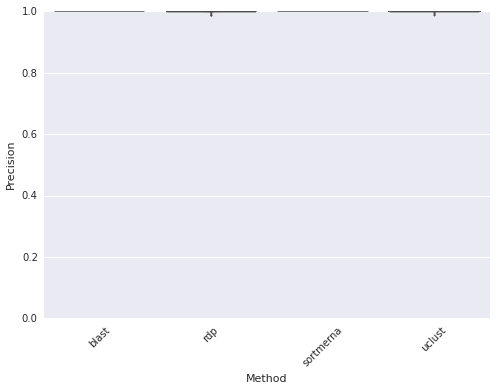

In [8]:
boxplot_from_data_frame(simulated_results, group_by="Method", metric="Precision")

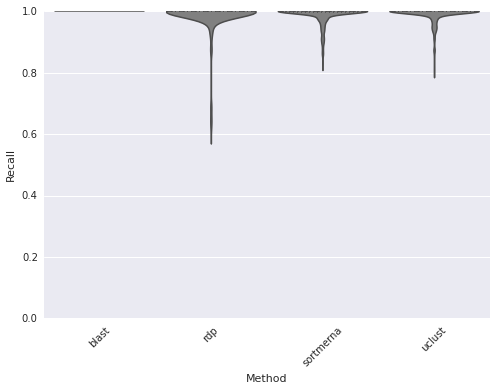

In [9]:
boxplot_from_data_frame(simulated_results, group_by="Method", metric="Recall")

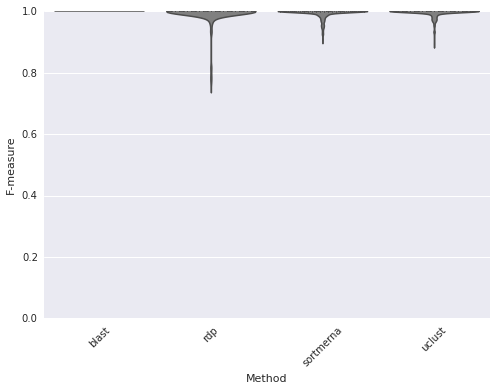

In [10]:
boxplot_from_data_frame(simulated_results, group_by="Method", metric="F-measure")

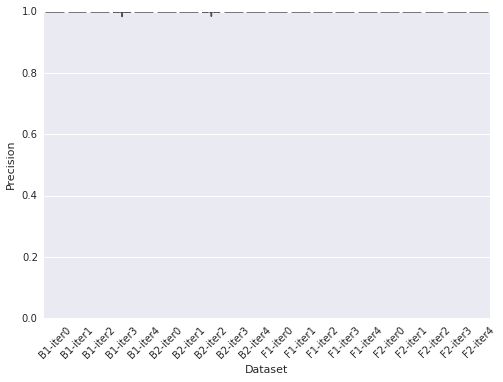

In [11]:
boxplot_from_data_frame(simulated_results, group_by="Dataset", metric="Precision")

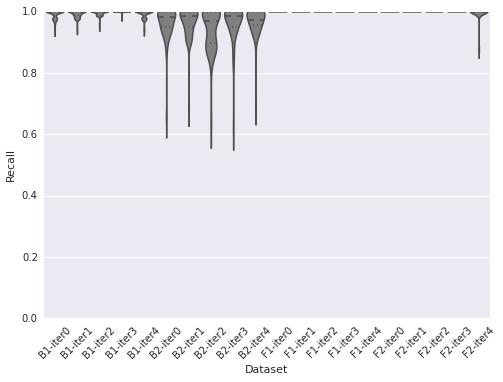

In [12]:
boxplot_from_data_frame(simulated_results, group_by="Dataset", metric="Recall")

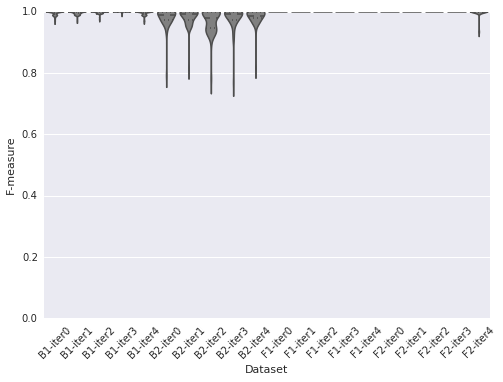

In [13]:
boxplot_from_data_frame(simulated_results, group_by="Dataset", metric="F-measure")

/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


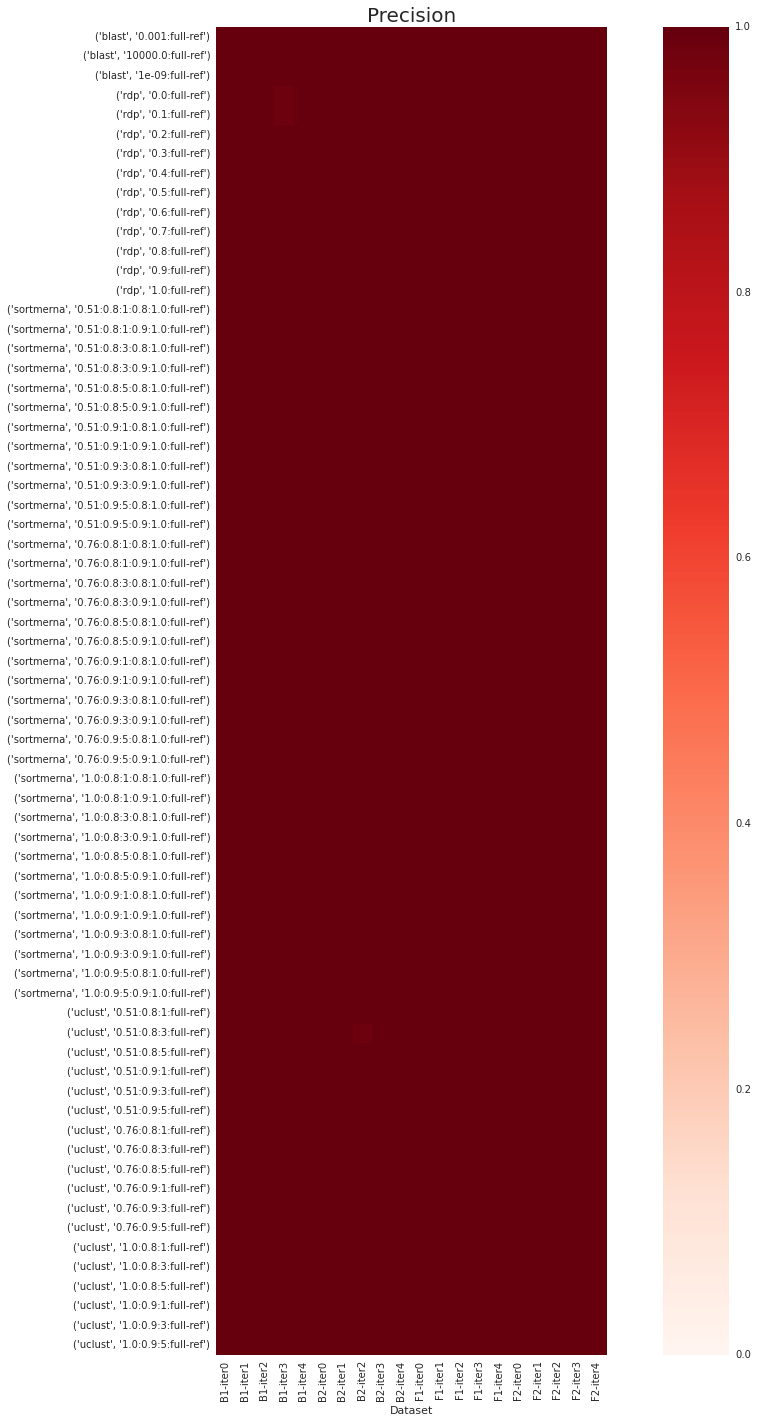

In [14]:
heatmap_from_data_frame(simulated_results, "Precision")

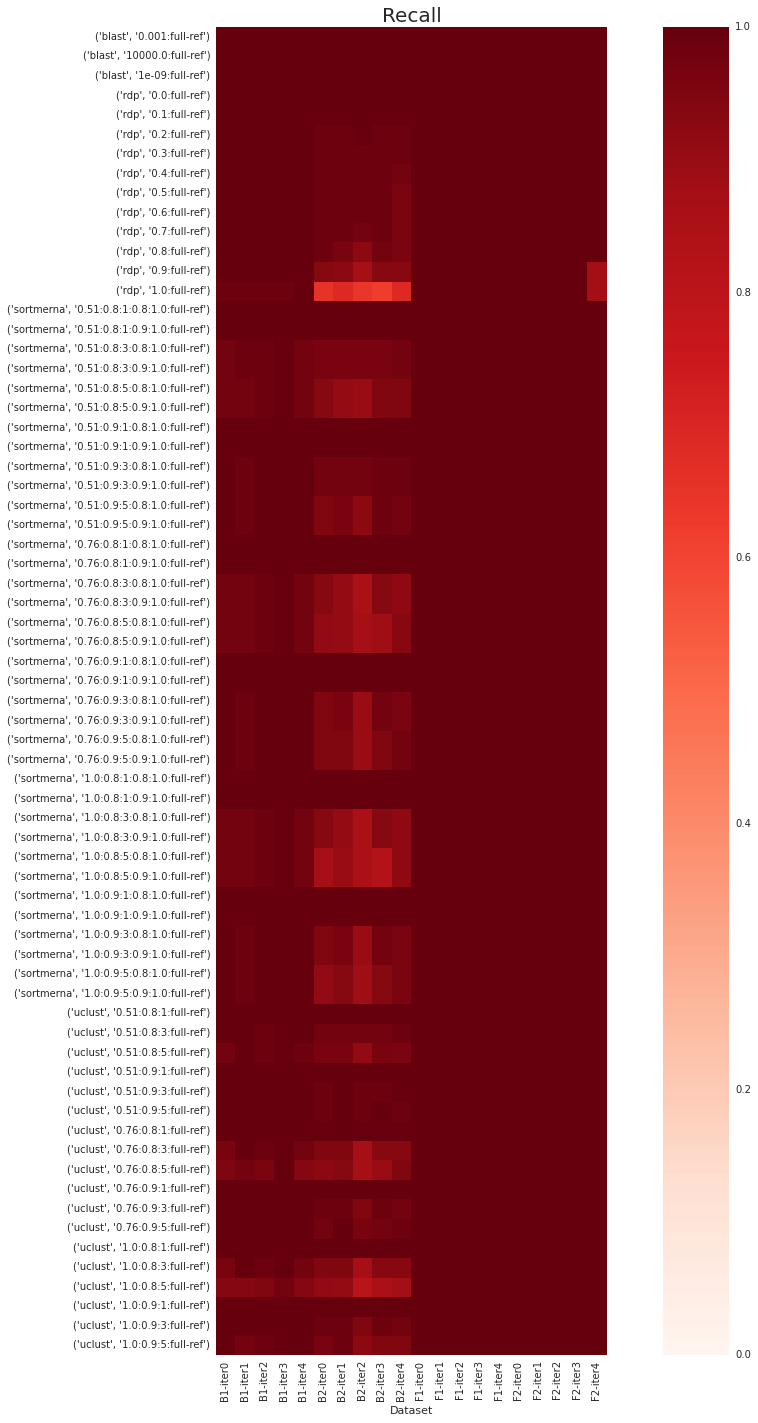

In [15]:
heatmap_from_data_frame(simulated_results, "Recall")

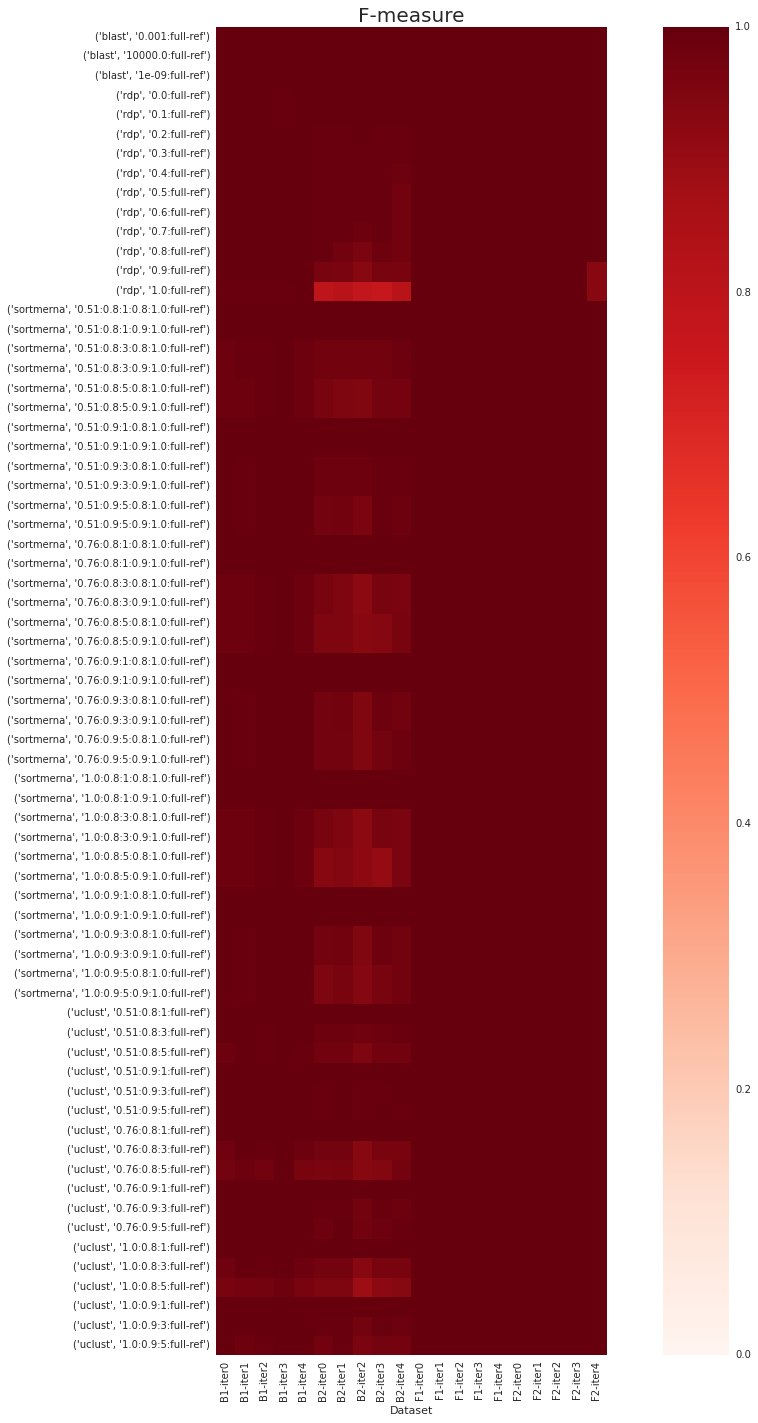

In [16]:
heatmap_from_data_frame(simulated_results, "F-measure")

In [17]:
method_by_dataset_a1(simulated_results, 'B1-iter0')

Method  Precision  Recall  F-measure
140  sortmerna          1       1          1
230        rdp          1       1          1
209      blast          1       1          1
236     uclust          1       1          1

In [18]:
method_by_dataset_a1(simulated_results, 'B2-iter0')

Method  Precision  Recall  F-measure
2044  sortmerna          1       1          1
2172     uclust          1       1          1
2131        rdp          1       1          1
2115      blast          1       1          1

In [19]:
method_by_dataset_a1(simulated_results, 'F1-iter0')

Method  Precision  Recall  F-measure
1908  sortmerna          1       1          1
1991        rdp          1       1          1
1979      blast          1       1          1
2004     uclust          1       1          1

In [20]:
method_by_dataset_a1(simulated_results, 'F2-iter0')

Method  Precision  Recall  F-measure
1092  sortmerna          1       1          1
1175        rdp          1       1          1
1163      blast          1       1          1
1188     uclust          1       1          1

## Evaluation 2: Rank-based statistics comparing the performance of the optimal parameter setting run for each method on each data set.

*Count best* column indicates how many samples a given method achieved the best result or tied for the best result (which is why they sum to more than the total number of samples).

### Within-method comparisons of parameter performance

In [21]:
rdp_top_params = parameter_comparisons(simulated_results, "rdp", metrics=['Precision', 'Recall', 'F-measure'])
rdp_top_params[:15]

F-measure  Precision  Recall       Mean
0.0:full-ref         19         19      20  19.333333
0.1:full-ref         19         19      20  19.333333
0.2:full-ref         16         20      16  17.333333
0.3:full-ref         15         20      15  16.666667
0.4:full-ref         15         20      15  16.666667
0.5:full-ref         15         20      15  16.666667
0.6:full-ref         15         20      15  16.666667
0.7:full-ref         15         20      15  16.666667
0.8:full-ref         15         20      15  16.666667
0.9:full-ref         14         20      14  16.000000
1.0:full-ref         10         20      10  13.333333

In [22]:
uclust_top_params = parameter_comparisons(simulated_results, "uclust", metrics=['Precision', 'Recall', 'F-measure'])
uclust_top_params[:15]

F-measure  Precision  Recall       Mean
0.51:0.8:1:full-ref         20         20      20  20.000000
0.76:0.8:1:full-ref         20         20      20  20.000000
1.0:0.9:1:full-ref          20         20      20  20.000000
1.0:0.8:1:full-ref          20         20      20  20.000000
0.76:0.9:1:full-ref         20         20      20  20.000000
0.51:0.9:1:full-ref         20         20      20  20.000000
0.51:0.9:5:full-ref         17         20      17  18.000000
0.51:0.9:3:full-ref         17         20      17  18.000000
0.76:0.9:5:full-ref         16         20      16  17.333333
0.76:0.9:3:full-ref         15         20      15  16.666667
1.0:0.9:3:full-ref          15         20      15  16.666667
0.51:0.8:3:full-ref         14         19      14  15.666667
1.0:0.9:5:full-ref          13         20      13  15.333333
0.76:0.8:3:full-ref         12         20      12  14.666667
1.0:0.8:3:full-ref          12         20      12  14.666667

In [23]:
sortmerna_top_params = parameter_comparisons(simulated_results, "sortmerna", metrics=['Precision', 'Recall', 'F-measure'])
sortmerna_top_params[:15]

F-measure  Precision  Recall  Mean
0.51:0.8:1:0.8:1.0:full-ref         20         20      20    20
0.76:0.8:1:0.8:1.0:full-ref         20         20      20    20
1.0:0.9:1:0.9:1.0:full-ref          20         20      20    20
1.0:0.9:1:0.8:1.0:full-ref          20         20      20    20
1.0:0.8:1:0.9:1.0:full-ref          20         20      20    20
1.0:0.8:1:0.8:1.0:full-ref          20         20      20    20
0.76:0.9:1:0.9:1.0:full-ref         20         20      20    20
0.51:0.8:1:0.9:1.0:full-ref         20         20      20    20
0.76:0.8:1:0.9:1.0:full-ref         20         20      20    20
0.76:0.9:1:0.8:1.0:full-ref         20         20      20    20
0.51:0.9:1:0.9:1.0:full-ref         20         20      20    20
0.51:0.9:1:0.8:1.0:full-ref         20         20      20    20
0.51:0.9:5:0.8:1.0:full-ref         14         20      14    16
0.76:0.9:3:0.8:1.0:full-ref         14         20      14    16
1.0:0.9:5:0.8:1.0:full-ref          14         20      14    16

In [24]:
blast_top_params = parameter_comparisons(simulated_results, "blast", metrics=['Precision', 'Recall', 'F-measure'])
blast_top_params[:15]

F-measure  Precision  Recall  Mean
0.001:full-ref           20         20      20    20
10000.0:full-ref         20         20      20    20
1e-09:full-ref           20         20      20    20

### Between-method performance comparisons based on best parameter set determined above

In [25]:
mp_combs = {"rdp": rdp_top_params.index[0],
            "blast": blast_top_params.index[0], 
            "sortmerna": sortmerna_top_params.index[0],
            "uclust": uclust_top_params.index[0]}

In [26]:
metric = 'Precision'
df = performance_rank_comparisons(simulated_results, metric, mp_combs)
if write_xls_files: 
    df.to_excel('tables/level%d_%s_rankstats.xlsx' % (taxonomic_level, metric), 
                                      na_rep='NA', float_format="%1.3f")
df

/usr/local/lib/python2.7/dist-packages/scipy/stats/morestats.py:1967: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


Count best  blast: wilcoxon stat  blast: wilcoxon p  \
blast              20                   NaN                NaN   
sortmerna          20                     0           1.000000   
uclust             20                     0           1.000000   
rdp                19                     0           0.317311   

           sortmerna: wilcoxon stat  sortmerna: wilcoxon p  \
blast                             0               1.000000   
sortmerna                       NaN                    NaN   
uclust                            0               1.000000   
rdp                               0               0.317311   

           uclust: wilcoxon stat  uclust: wilcoxon p  rdp: wilcoxon stat  \
blast                          0            1.000000                   0   
sortmerna                      0            1.000000                   0   
uclust                       NaN                 NaN                   0   
rdp                            0            0.317311                 NaN   

           rdp: wilcoxon p  
blast             0.317311  
sortmerna         0.317311  
uclust            0.317311  
rdp                    NaN

In [27]:
metric = 'Recall'
df = performance_rank_comparisons(simulated_results, metric, mp_combs)
if write_xls_files: 
    df.to_excel('tables/level%d_%s_rankstats.xlsx' % (taxonomic_level, metric), 
                                      na_rep='NA', float_format="%1.3f")
df

Count best  blast: wilcoxon stat  blast: wilcoxon p  \
blast              20                   NaN                NaN   
rdp                20                     0                  1   
sortmerna          20                     0                  1   
uclust             20                     0                  1   

           rdp: wilcoxon stat  rdp: wilcoxon p  sortmerna: wilcoxon stat  \
blast                       0                1                         0   
rdp                       NaN              NaN                         0   
sortmerna                   0                1                       NaN   
uclust                      0                1                         0   

           sortmerna: wilcoxon p  uclust: wilcoxon stat  uclust: wilcoxon p  
blast                          1                      0                   1  
rdp                            1                      0                   1  
sortmerna                    NaN                      0                   1  
uclust                         1                    NaN                 NaN

In [28]:
metric = 'F-measure'
df = performance_rank_comparisons(simulated_results, metric, mp_combs)
if write_xls_files: 
    df.to_excel('tables/level%d_%s_rankstats.xlsx' % (taxonomic_level, metric), 
                                      na_rep='NA', float_format="%1.3f")
df

Count best  blast: wilcoxon stat  blast: wilcoxon p  \
blast              20                   NaN                NaN   
sortmerna          20                     0           1.000000   
uclust             20                     0           1.000000   
rdp                19                     0           0.317311   

           sortmerna: wilcoxon stat  sortmerna: wilcoxon p  \
blast                             0               1.000000   
sortmerna                       NaN                    NaN   
uclust                            0               1.000000   
rdp                               0               0.317311   

           uclust: wilcoxon stat  uclust: wilcoxon p  rdp: wilcoxon stat  \
blast                          0            1.000000                   0   
sortmerna                      0            1.000000                   0   
uclust                       NaN                 NaN                   0   
rdp                            0            0.317311                 NaN   

           rdp: wilcoxon p  
blast             0.317311  
sortmerna         0.317311  
uclust            0.317311  
rdp                    NaN